ref: https://github.com/gecso75/finger-works/blob/main/xAPI-Edu-Data-desc.txt

In [1]:
import requests
import io
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adadelta
from keras.regularizers import l1
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
url = "https://raw.githubusercontent.com/gecso75/finger-works/main/xAPI-Edu-Data.csv"
download = requests.get(url).content
df = read_csv(io.StringIO(download.decode('utf-8')))

In [3]:
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [4]:
df.dtypes

gender                      object
NationalITy                 object
PlaceofBirth                object
StageID                     object
GradeID                     object
SectionID                   object
Topic                       object
Semester                    object
Relation                    object
raisedhands                  int64
VisITedResources             int64
AnnouncementsView            int64
Discussion                   int64
ParentAnsweringSurvey       object
ParentschoolSatisfaction    object
StudentAbsenceDays          object
Class                       object
dtype: object

In [5]:
X = df.copy()
y = X.pop('Class')

In [6]:
trans1 = ColumnTransformer([
    ('tr1', OneHotEncoder(drop='first'), [0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15])],
    remainder='passthrough',
    sparse_threshold=0
)
X = trans1.fit_transform(X)

trans2 = ColumnTransformer([
    ('tr1', StandardScaler(), [-1, -2, -3, -4])],
    remainder='passthrough'
)

y_bin = LabelBinarizer().fit_transform(y)

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X, y_bin, shuffle=True, test_size=0.2, random_state=1234)

In [9]:
model = Sequential()
model.add(Dense(18, input_dim=60, activation='relu', kernel_regularizer=l1(l=0.01)))
model.add(Dropout(0.20))
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(3, activation='softmax'))

opt = Adadelta(learning_rate=2.0, rho=0.90, epsilon=1e-7)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
lrate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_delta=1e-3)
history = model.fit(x=trans2.fit_transform(train_X),
                    y=train_y,
                    batch_size=16,
                    validation_data=(trans2.transform(test_X), test_y),
                    epochs=500, verbose=0, callbacks=[lrate])


Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.8.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 1.6199999570846557.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.4580000042915344.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 1.3121999502182007.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 1.1809799551963807.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 1.0628819704055787.

Epoch 00142: ReduceLROnPlateau reducing learning rate to 0.9565937519073486.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 0.8609343767166138.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.7748409390449524.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 0.6973568558692932.

Epoch 00182: ReduceLROnPlateau reducing learning rate to 0.627621191740036.

Epoch 00192: ReduceLROnPlateau reducing learning rate to 0.5648590564727783.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 0.5083731293678284.

E

In [11]:
pred = model.predict_classes(trans2.transform(test_X))
print(confusion_matrix(y_true=np.argmax(test_y, axis=-1), y_pred=pred))
print(classification_report(y_true=np.argmax(test_y, axis=-1), y_pred=pred))

[[24  0  5]
 [ 0 19  1]
 [10  3 34]]
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        29
           1       0.86      0.95      0.90        20
           2       0.85      0.72      0.78        47

    accuracy                           0.80        96
   macro avg       0.81      0.83      0.82        96
weighted avg       0.81      0.80      0.80        96



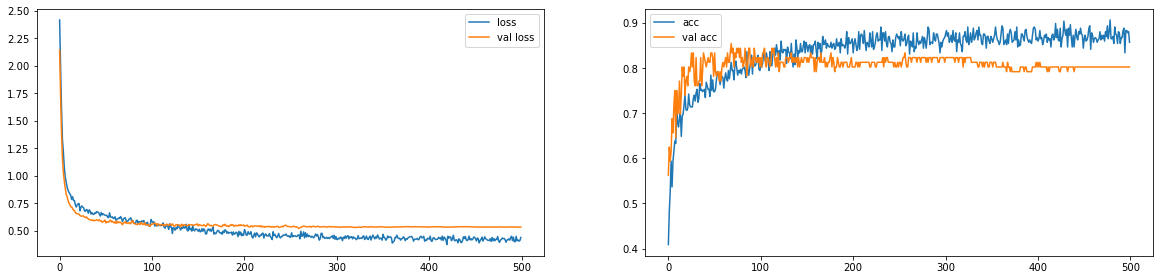

In [12]:
pyplot.figure(figsize=(20, 10))
pyplot.subplot(221)
pyplot.plot(history.history['loss'], label="loss")
pyplot.plot(history.history['val_loss'], label="val loss")
pyplot.legend()
pyplot.subplot(222)
pyplot.plot(history.history['categorical_accuracy'], label="acc")
pyplot.plot(history.history['val_categorical_accuracy'], label="val acc")
pyplot.legend()
pyplot.show()

looks like the model is kindly overfitted